In this notebook we will train the LGBM model with train-validation split to evaluate the model's performance

# Import libraries

In [1]:
from pathlib import Path
import joblib
import re

#Data manipulation
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Sktime
!pip install sktime --quiet
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

# Light gradient boosting machine (LightGBM regression)
import lightgbm as lgbm

# The pipeline will output a pandas dataframe (rather than a numpy array)
from sklearn import set_config
from sklearn.metrics import make_scorer

set_config(transform_output="pandas")

# Accessing Google Drive
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 10.4 MB/s eta 0:00:00
Mounted at /content/drive


# Utility functions

In [2]:
#--- Function to reduce memory usage ---#
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# Function that returns Root-Mean-Squared-Log-Error (RMSLE)
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred, squared=False):
    rmsle_score = mean_squared_log_error(y_true, y_pred, squared=False)    # squared=False returns RMSLE
    return ('rmsle', rmsle_score, False)


# # Create the Root-Mean-Squared-Log-Error (RMSLE) metric
# rmsle_pos = make_scorer(rmsle)
# rmsle_pos
# # Create the the negative version of Root-Mean-Squared-Log-Error (RMSLE) metric, which is best when maximized.
#This will come handy later as GridSearchCV always tries to maximize a score
# rmsle_neg = make_scorer(rmsle, greater_is_better=False)
# rmsle_neg

# #See Houses_kaggle_competition.ipynb

In [4]:
def scorethis_rmsle(y_true, y_pred):

    scorelist = list()

    for x in range(y_pred.__len__()):

        log_score_x = np.abs(np.abs(y_pred[x]) - np.abs(y_true[x]))

        try:
            [scorelist.append(y) for y in log_score_x.values]
        except:
            scorelist.append(log_score_x)

    score_array = np.array(scorelist)

    rmsle_score = np.sqrt(np.mean(score_array**2)) # sqrt of mean of power of difference of the logs
    rmsle_score = np.round(rmsle_score, 3)

    return ('rmsle', rmsle_score, False)

# X_train and y_train --> X_tr and y_tr, X_val and y_val

In [ ]:
# #------ LOAD THE TRAIN DATA ------#
# #--- For_models directory for storing the processed data and pipelines ---#
# data_from_pipelines_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/data_from_pipelines")

# #--- Load the processed train data ---#
# train_data_dir = data_from_pipelines_dir / "data_from_pipeline_lgbm_scaled/train_data_from_pipeline_lgbm_scaled.parquet"
# train_data = pd.read_parquet(path=train_data_dir)

# # #--- Reduce size of train_data to fit the model ---#
# # train_data = reduce_memory_usage_2(train_data)
# train_data.head()

# #--- To check for start date of train (exclude NaN rows) ---#
# date_index = train_data.index.get_level_values(1)
# date_mask = date_index < (date_index.min() + np.timedelta64(60, "D"))
# check = train_data.loc[date_mask]
# # check.loc[("10_AUTOMOTIVE", "2013-01-31"):("10_AUTOMOTIVE", "2013-03-02")

# drop_index = check.loc['10_AUTOMOTIVE'][check.loc['10_AUTOMOTIVE']['sales_mean_28_28'].isna()].index
# print(drop_index,'\n', drop_index[-1] - drop_index[0] + np.timedelta64(1, "D"))

# del check

#################################################################################
# #------ X_train ------#
# # Drop 'sales', 'store_nbr', 'family', 'transactions' columns
# X_train = train_data.drop(columns=['sales', 'store_nbr', 'family', 'transactions'])

# # Exclude rows that have NaN values in lag and window columns, and rename the columns for LightGBM
# X_train = X_train.loc[X_train.index.get_level_values(1) > drop_index[-1]]
# X_train = X_train.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "_", x))

# #------ y_train ------#
# y_train = train_data[["sales"]].loc[train_data[["sales"]].index.get_level_values(1) > drop_index[-1]]

# print(X_train.shape, y_train.shape)
# print("X_train:", "\n Start date is ", X_train.index.min()[1], "\n End date is ", X_train.index.max()[1])

#################################################################################
# #------ Train-validation split from X_train ------#
# # We use the last 30 days of X_train for validation
# date_index = X_train.index.get_level_values(-1)
# train_date_mask = date_index <= date_index.max() - np.timedelta64(30, "D")
# validation_date_mask = date_index > date_index.max() - np.timedelta64(30, "D")

# X_tr = X_train.loc[train_date_mask]
# y_tr = y_train.loc[train_date_mask]

# X_val = X_train.loc[validation_date_mask]
# y_val = y_train.loc[validation_date_mask]

# print(X_tr.index.get_level_values(-1), "\n", X_val.index.get_level_values(-1))

#################################################################################
# #------ Save the train-validation set ------#
# # Set directory
# data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/data_from_pipelines/data_from_pipeline_lgbm_scaled")

# # Save the datasets with ewm and encoded features

# out_dir = data_dir / "X_tr.parquet"
# X_tr.to_parquet(path=out_dir, index=True)
# out_dir = data_dir / "y_tr.parquet"
# y_tr.to_parquet(path=out_dir, index=True)

# out_dir = data_dir / "X_val.parquet"
# X_val.to_parquet(path=out_dir, index=True)
# out_dir = data_dir / "y_val.parquet"
# y_val.to_parquet(path=out_dir, index=True)

# Load train-validation set

In [5]:
# Load train-validation set
# We use the last 30 days of X_train for validation
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/data_from_pipelines/data_from_pipeline_lgbm_scaled")
X_tr_dir = data_dir / "X_tr.parquet"
y_tr_dir = data_dir / "y_tr.parquet"
X_val_dir = data_dir / "X_val.parquet"
y_val_dir = data_dir / "y_val.parquet"

X_tr = pd.read_parquet(path=X_tr_dir)
y_tr = pd.read_parquet(path=y_tr_dir)
X_val = pd.read_parquet(path=X_val_dir)
y_val = pd.read_parquet(path=y_val_dir)

print(X_tr.index.get_level_values(-1), "\n", X_val.index.get_level_values(-1))

DatetimeIndex(['2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28',
               '2013-03-01', '2013-03-02', '2013-03-03', '2013-03-04',
               '2013-03-05', '2013-03-06',
               ...
               '2017-07-07', '2017-07-08', '2017-07-09', '2017-07-10',
               '2017-07-11', '2017-07-12', '2017-07-13', '2017-07-14',
               '2017-07-15', '2017-07-16'],
              dtype='datetime64[ns]', name='date', length=2849418, freq=None) 
 DatetimeIndex(['2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=53460, freq=None)


# Tune LGBMR Model using Optuna

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

* High variance / Overfitting:
  * The model has paid too much attention to both signal and noise in the training data, leading to high training scores.
  * Reliance on noise does not generalize well on unseen data, resulting in low test scores.

* High bias / Underfitting:
  * Low scores in both training and test sets.
  * Training and testing scores converge and plateau at a low score.
  * No matter how much data is used for training, the model cannot determine a meaningful relationship.

* Ideal curves:
  * High scores on both training set and test set
  * Converged curves (at high scores for both training set and test set)

In [ ]:
# Tree Shape — num_leaves and max_depth
# Tree Growth — min_data_in_leaf and min_gain_to_split
# Data Sampling — bagging_fraction, bagging_freq, and feature_fraction
# Regularization — lambda_l1 and lambda_l2

# hyperparameters of the most tree-based models can be grouped into 4 categories:

# Parameters that affect the structure and learning of the decision trees
# Parameters that affect the training speed
# Parameters for better accuracy
# Parameters to combat overfitting

In [ ]:
def objective(trial):
    X_train = X_tr
    y_train = y_tr
    X_validation = X_val
    y_validation = y_val

    cat_cols = X_train.select_dtypes("category").columns.tolist()

    fixed_params = {
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        # 'boost_from_average': True,
        'early_stopping_round': 100,        # 10% * n_estimators
        'verbose': -1,
        'seed': 42         #random_state
        }

    search_params = {
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1, 1.9, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_categorical('max_depth', [7, 8, 9, 10, 11]),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 300, step=50),       #min_child_samples
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.8, step=0.1),   #colsample_bytree
        'max_bin': trial.suggest_int('max_bin', 100, 300),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000, 1500]),
        'subsample': trial.suggest_float('subsample', 0.2, 0.8, step=0.1),                 # bagging_fraction
        'subsample_freq': trial.suggest_categorical("bagging_freq", [1]),                   # bagging_freq
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 10, 100)
        }


    params = {**fixed_params, **search_params}
    model = lgbm.LGBMRegressor(**params)
    model.fit(X=X_train, y=y_train, eval_set=[(X_validation, y_validation), (X_train, y_train)], categorical_feature = cat_cols, eval_metric=[rmsle])
    # best_score = model.best_score_

    y_pred = model.predict(X_validation)
    rmsle_score = mean_squared_log_error(y_validation, y_pred, squared=False)

    # lgbm.plot_metric(model)
    # plt.show()
    return rmsle_score

In [ ]:
!pip install optuna --quiet
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params, '\n')

[I 2023-06-22 07:20:12,520] A new study created in memory with name: no-name-8bf5f1ef-6c02-4e3e-b395-1132d4112d1e
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 27.0234	training's rmsle: 3.86543	valid_0's tweedie: 29.4559	valid_0's rmsle: 3.28836
[2]	training's tweedie: 26.2268	training's rmsle: 3.73716	valid_0's tweedie: 28.6445	valid_0's rmsle: 3.16976
[3]	training's tweedie: 25.4828	training's rmsle: 3.61055	valid_0's tweedie: 27.8881	valid_0's rmsle: 3.05308
[4]	training's tweedie: 24.7824	training's rmsle: 3.48516	valid_0's tweedie: 27.1767	valid_0's rmsle: 2.93764
[5]	training's tweedie: 24.127	training's rmsle: 3.36093	valid_0's tweedie: 26.5155	valid_0's rmsle: 2.82438
[6]	training's tweedie: 23.5111	training's rmsle: 3.23803	valid_0's tweedie: 25.8984	valid_0's rmsle: 2.71278
[7]	training's tweedie: 22.9377	training's rmsle: 3.11687	valid_0's tweedie: 25.324	valid_0's rmsle: 2.60346
[8]	training's tweedie: 22.403	training's rmsle: 2.9978	valid_0's tweedie: 24.7895	valid_0's rmsle: 2.49623
[9]	training's tweedie: 21.9065	training's rmsle: 2.88136	valid_0's tweedie: 24.2947	valid_0's rmsle: 2.39133
[10]	training'

[I 2023-06-22 07:26:51,784] Trial 0 finished with value: 0.4056600351102185 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'learning_rate': 0.052401756198114526, 'max_depth': 7, 'num_leaves': 750, 'min_data_in_leaf': 250, 'feature_fraction': 0.2, 'max_bin': 224, 'n_estimators': 1500, 'subsample': 0.30000000000000004, 'bagging_freq': 1, 'min_data_per_groups': 49}. Best is trial 0 with value: 0.4056600351102185.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 73.2936	training's rmsle: 3.89588	valid_0's tweedie: 84.1288	valid_0's rmsle: 3.3142
[2]	training's tweedie: 70.7441	training's rmsle: 3.79749	valid_0's tweedie: 81.2918	valid_0's rmsle: 3.22056
[3]	training's tweedie: 68.3936	training's rmsle: 3.69996	valid_0's tweedie: 78.6914	valid_0's rmsle: 3.12816
[4]	training's tweedie: 66.2214	training's rmsle: 3.60318	valid_0's tweedie: 76.29	valid_0's rmsle: 3.03674
[5]	training's tweedie: 64.2194	training's rmsle: 3.50729	valid_0's tweedie: 74.0787	valid_0's rmsle: 2.94632
[6]	training's tweedie: 62.3734	training's rmsle: 3.4122	valid_0's tweedie: 72.0459	valid_0's rmsle: 2.85709
[7]	training's tweedie: 60.6723	training's rmsle: 3.31799	valid_0's tweedie: 70.1838	valid_0's rmsle: 2.76912
[8]	training's tweedie: 59.107	training's rmsle: 3.2246	valid_0's tweedie: 68.4794	valid_0's rmsle: 2.68252
[9]	training's tweedie: 57.6708	training's rmsle: 3.13237	valid_0's tweedie: 66.9233	valid_0's rmsle: 2.59702
[10]	training's 

[I 2023-06-22 07:37:27,921] Trial 1 finished with value: 0.3978806374350926 and parameters: {'tweedie_variance_power': 1.5, 'learning_rate': 0.06379974645941786, 'max_depth': 7, 'num_leaves': 700, 'min_data_in_leaf': 100, 'feature_fraction': 0.5, 'max_bin': 231, 'n_estimators': 1500, 'subsample': 0.2, 'bagging_freq': 1, 'min_data_per_groups': 76}. Best is trial 1 with value: 0.3978806374350926.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 43.0629	training's rmsle: 3.92928	valid_0's tweedie: 48.1525	valid_0's rmsle: 3.34657
[2]	training's tweedie: 42.2075	training's rmsle: 3.86388	valid_0's tweedie: 47.2363	valid_0's rmsle: 3.28485
[3]	training's tweedie: 41.385	training's rmsle: 3.79864	valid_0's tweedie: 46.36	valid_0's rmsle: 3.22359
[4]	training's tweedie: 40.5935	training's rmsle: 3.7335	valid_0's tweedie: 45.5187	valid_0's rmsle: 3.16262
[5]	training's tweedie: 39.8353	training's rmsle: 3.66874	valid_0's tweedie: 44.7123	valid_0's rmsle: 3.10201
[6]	training's tweedie: 39.1082	training's rmsle: 3.6043	valid_0's tweedie: 43.9396	valid_0's rmsle: 3.04186
[7]	training's tweedie: 38.4117	training's rmsle: 3.54031	valid_0's tweedie: 43.2019	valid_0's rmsle: 2.98222
[8]	training's tweedie: 37.7455	training's rmsle: 3.47679	valid_0's tweedie: 42.4971	valid_0's rmsle: 2.92325
[9]	training's tweedie: 37.1062	training's rmsle: 3.41344	valid_0's tweedie: 41.8233	valid_0's rmsle: 2.86461
[10]	training's

[I 2023-06-22 07:49:34,263] Trial 2 finished with value: 0.4004253032857621 and parameters: {'tweedie_variance_power': 1.6, 'learning_rate': 0.03471157329187182, 'max_depth': 7, 'num_leaves': 450, 'min_data_in_leaf': 100, 'feature_fraction': 0.30000000000000004, 'max_bin': 295, 'n_estimators': 1500, 'subsample': 0.30000000000000004, 'bagging_freq': 1, 'min_data_per_groups': 71}. Best is trial 1 with value: 0.3978806374350926.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 285.015	training's rmsle: 3.92502	valid_0's tweedie: 343.523	valid_0's rmsle: 3.33994
[2]	training's tweedie: 276.747	training's rmsle: 3.85578	valid_0's tweedie: 333.572	valid_0's rmsle: 3.27208
[3]	training's tweedie: 269.213	training's rmsle: 3.78736	valid_0's tweedie: 324.579	valid_0's rmsle: 3.20536
[4]	training's tweedie: 262.336	training's rmsle: 3.71955	valid_0's tweedie: 316.387	valid_0's rmsle: 3.13952
[5]	training's tweedie: 256.079	training's rmsle: 3.6525	valid_0's tweedie: 308.945	valid_0's rmsle: 3.07463
[6]	training's tweedie: 250.383	training's rmsle: 3.58604	valid_0's tweedie: 302.201	valid_0's rmsle: 3.0106
[7]	training's tweedie: 245.202	training's rmsle: 3.52015	valid_0's tweedie: 296.112	valid_0's rmsle: 2.94757
[8]	training's tweedie: 240.502	training's rmsle: 3.45488	valid_0's tweedie: 290.638	valid_0's rmsle: 2.88548
[9]	training's tweedie: 236.239	training's rmsle: 3.39029	valid_0's tweedie: 285.72	valid_0's rmsle: 2.82413
[10]	training

[I 2023-06-22 08:19:10,860] Trial 3 finished with value: 0.3943741693361258 and parameters: {'tweedie_variance_power': 1.3, 'learning_rate': 0.05981696775465075, 'max_depth': 10, 'num_leaves': 100, 'min_data_in_leaf': 200, 'feature_fraction': 0.5, 'max_bin': 179, 'n_estimators': 1500, 'subsample': 0.4, 'bagging_freq': 1, 'min_data_per_groups': 81}. Best is trial 3 with value: 0.3943741693361258.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 41.6673	training's rmsle: 3.82174	valid_0's tweedie: 46.6676	valid_0's rmsle: 3.24554
[2]	training's tweedie: 39.612	training's rmsle: 3.65025	valid_0's tweedie: 44.483	valid_0's rmsle: 3.08515
[3]	training's tweedie: 37.7774	training's rmsle: 3.48142	valid_0's tweedie: 42.5424	valid_0's rmsle: 2.92802
[4]	training's tweedie: 36.1368	training's rmsle: 3.31473	valid_0's tweedie: 40.8159	valid_0's rmsle: 2.77412
[5]	training's tweedie: 34.6722	training's rmsle: 3.15053	valid_0's tweedie: 39.2813	valid_0's rmsle: 2.62336
[6]	training's tweedie: 33.3675	training's rmsle: 2.989	valid_0's tweedie: 37.9212	valid_0's rmsle: 2.47624
[7]	training's tweedie: 32.2085	training's rmsle: 2.83051	valid_0's tweedie: 36.7215	valid_0's rmsle: 2.33322
[8]	training's tweedie: 31.1789	training's rmsle: 2.67478	valid_0's tweedie: 35.6678	valid_0's rmsle: 2.19432
[9]	training's tweedie: 30.2685	training's rmsle: 2.52284	valid_0's tweedie: 34.7434	valid_0's rmsle: 2.05919
[10]	training'

[I 2023-06-22 08:24:15,119] Trial 4 finished with value: 0.39799570345450336 and parameters: {'tweedie_variance_power': 1.6, 'learning_rate': 0.09106804050259042, 'max_depth': 10, 'num_leaves': 550, 'min_data_in_leaf': 100, 'feature_fraction': 0.5, 'max_bin': 166, 'n_estimators': 1500, 'subsample': 0.4, 'bagging_freq': 1, 'min_data_per_groups': 34}. Best is trial 3 with value: 0.3943741693361258.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 136.059	training's rmsle: 3.87989	valid_0's tweedie: 160.118	valid_0's rmsle: 3.29737
[2]	training's tweedie: 130.075	training's rmsle: 3.76601	valid_0's tweedie: 153.194	valid_0's rmsle: 3.18778
[3]	training's tweedie: 124.762	training's rmsle: 3.65377	valid_0's tweedie: 147.086	valid_0's rmsle: 3.08008
[4]	training's tweedie: 120.035	training's rmsle: 3.54254	valid_0's tweedie: 141.683	valid_0's rmsle: 2.97422
[5]	training's tweedie: 115.85	training's rmsle: 3.43283	valid_0's tweedie: 136.925	valid_0's rmsle: 2.87
[6]	training's tweedie: 112.146	training's rmsle: 3.32432	valid_0's tweedie: 132.734	valid_0's rmsle: 2.76762
[7]	training's tweedie: 108.87	training's rmsle: 3.21708	valid_0's tweedie: 129.067	valid_0's rmsle: 2.66723
[8]	training's tweedie: 105.982	training's rmsle: 3.11111	valid_0's tweedie: 125.867	valid_0's rmsle: 2.56879
[9]	training's tweedie: 103.441	training's rmsle: 3.00667	valid_0's tweedie: 123.085	valid_0's rmsle: 2.47202
[10]	training's

[I 2023-06-22 08:38:53,483] Trial 5 finished with value: 0.3928188133164618 and parameters: {'tweedie_variance_power': 1.4, 'learning_rate': 0.08684106832333718, 'max_depth': 9, 'num_leaves': 850, 'min_data_in_leaf': 250, 'feature_fraction': 0.4, 'max_bin': 257, 'n_estimators': 1500, 'subsample': 0.5, 'bagging_freq': 1, 'min_data_per_groups': 46}. Best is trial 5 with value: 0.3928188133164618.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 26.8324	training's rmsle: 3.83541	valid_0's tweedie: 29.2626	valid_0's rmsle: 3.26051
[2]	training's tweedie: 25.8689	training's rmsle: 3.67754	valid_0's tweedie: 28.2834	valid_0's rmsle: 3.11471
[3]	training's tweedie: 24.9807	training's rmsle: 3.52198	valid_0's tweedie: 27.385	valid_0's rmsle: 2.97172
[4]	training's tweedie: 24.1599	training's rmsle: 3.36817	valid_0's tweedie: 26.5584	valid_0's rmsle: 2.8314
[5]	training's tweedie: 23.4029	training's rmsle: 3.21662	valid_0's tweedie: 25.7976	valid_0's rmsle: 2.69384
[6]	training's tweedie: 22.7056	training's rmsle: 3.0674	valid_0's tweedie: 25.1	valid_0's rmsle: 2.55916
[7]	training's tweedie: 22.0646	training's rmsle: 2.92071	valid_0's tweedie: 24.463	valid_0's rmsle: 2.42813
[8]	training's tweedie: 21.4742	training's rmsle: 2.77632	valid_0's tweedie: 23.881	valid_0's rmsle: 2.30045
[9]	training's tweedie: 20.9329	training's rmsle: 2.63494	valid_0's tweedie: 23.3481	valid_0's rmsle: 2.17574
[10]	training's tw

[I 2023-06-22 08:43:57,851] Trial 6 finished with value: 0.4042251994101103 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'learning_rate': 0.0643202583787401, 'max_depth': 10, 'num_leaves': 100, 'min_data_in_leaf': 300, 'feature_fraction': 0.6000000000000001, 'max_bin': 186, 'n_estimators': 1500, 'subsample': 0.6000000000000001, 'bagging_freq': 1, 'min_data_per_groups': 32}. Best is trial 5 with value: 0.3928188133164618.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 19.796	training's rmsle: 3.85222	valid_0's tweedie: 20.4066	valid_0's rmsle: 3.2823
[2]	training's tweedie: 19.5751	training's rmsle: 3.7112	valid_0's tweedie: 20.2103	valid_0's rmsle: 3.15859
[3]	training's tweedie: 19.3622	training's rmsle: 3.57234	valid_0's tweedie: 20.0222	valid_0's rmsle: 3.0377
[4]	training's tweedie: 19.1567	training's rmsle: 3.43534	valid_0's tweedie: 19.842	valid_0's rmsle: 2.91954
[5]	training's tweedie: 18.9584	training's rmsle: 3.30041	valid_0's tweedie: 19.6694	valid_0's rmsle: 2.80431
[6]	training's tweedie: 18.7675	training's rmsle: 3.16785	valid_0's tweedie: 19.5045	valid_0's rmsle: 2.69211
[7]	training's tweedie: 18.5839	training's rmsle: 3.03773	valid_0's tweedie: 19.3472	valid_0's rmsle: 2.58327
[8]	training's tweedie: 18.4068	training's rmsle: 2.90987	valid_0's tweedie: 19.1969	valid_0's rmsle: 2.47745
[9]	training's tweedie: 18.2371	training's rmsle: 2.7851	valid_0's tweedie: 19.0534	valid_0's rmsle: 2.3749
[10]	training's t

[I 2023-06-22 08:49:40,109] Trial 7 finished with value: 0.47249208484661104 and parameters: {'tweedie_variance_power': 1.9, 'learning_rate': 0.020771020883403726, 'max_depth': 10, 'num_leaves': 850, 'min_data_in_leaf': 300, 'feature_fraction': 0.7, 'max_bin': 235, 'n_estimators': 1500, 'subsample': 0.30000000000000004, 'bagging_freq': 1, 'min_data_per_groups': 11}. Best is trial 5 with value: 0.3928188133164618.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 72.722	training's rmsle: 3.87449	valid_0's tweedie: 83.4968	valid_0's rmsle: 3.2939
[2]	training's tweedie: 69.6955	training's rmsle: 3.75501	valid_0's tweedie: 80.1362	valid_0's rmsle: 3.18052
[3]	training's tweedie: 66.9518	training's rmsle: 3.63695	valid_0's tweedie: 77.1045	valid_0's rmsle: 3.06884
[4]	training's tweedie: 64.4603	training's rmsle: 3.51984	valid_0's tweedie: 74.3602	valid_0's rmsle: 2.95864
[5]	training's tweedie: 62.2017	training's rmsle: 3.40396	valid_0's tweedie: 71.8842	valid_0's rmsle: 2.85002
[6]	training's tweedie: 60.1595	training's rmsle: 3.28937	valid_0's tweedie: 69.6514	valid_0's rmsle: 2.74314
[7]	training's tweedie: 58.3135	training's rmsle: 3.17615	valid_0's tweedie: 67.6461	valid_0's rmsle: 2.63824
[8]	training's tweedie: 56.646	training's rmsle: 3.06408	valid_0's tweedie: 65.8477	valid_0's rmsle: 2.53513
[9]	training's tweedie: 55.1442	training's rmsle: 2.95358	valid_0's tweedie: 64.2419	valid_0's rmsle: 2.43376
[10]	training

[I 2023-06-22 08:58:48,120] Trial 8 finished with value: 0.39076410159419667 and parameters: {'tweedie_variance_power': 1.5, 'learning_rate': 0.07738288912386584, 'max_depth': 11, 'num_leaves': 950, 'min_data_in_leaf': 100, 'feature_fraction': 0.4, 'max_bin': 253, 'n_estimators': 1500, 'subsample': 0.7, 'bagging_freq': 1, 'min_data_per_groups': 57}. Best is trial 8 with value: 0.39076410159419667.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 282.873	training's rmsle: 3.90781	valid_0's tweedie: 340.941	valid_0's rmsle: 3.32263
[2]	training's tweedie: 272.888	training's rmsle: 3.82179	valid_0's tweedie: 328.903	valid_0's rmsle: 3.23809
[3]	training's tweedie: 263.944	training's rmsle: 3.73661	valid_0's tweedie: 318.244	valid_0's rmsle: 3.15524
[4]	training's tweedie: 255.977	training's rmsle: 3.65234	valid_0's tweedie: 308.791	valid_0's rmsle: 3.07374
[5]	training's tweedie: 248.904	training's rmsle: 3.56916	valid_0's tweedie: 300.447	valid_0's rmsle: 2.99364
[6]	training's tweedie: 242.638	training's rmsle: 3.4869	valid_0's tweedie: 293.103	valid_0's rmsle: 2.91494
[7]	training's tweedie: 237.084	training's rmsle: 3.40557	valid_0's tweedie: 286.667	valid_0's rmsle: 2.83767
[8]	training's tweedie: 232.178	training's rmsle: 3.32521	valid_0's tweedie: 281.023	valid_0's rmsle: 2.76172
[9]	training's tweedie: 227.839	training's rmsle: 3.24565	valid_0's tweedie: 276.118	valid_0's rmsle: 2.68698
[10]	traini

[I 2023-06-22 09:14:39,357] Trial 9 finished with value: 0.39230760442571194 and parameters: {'tweedie_variance_power': 1.3, 'learning_rate': 0.074853592093934, 'max_depth': 9, 'num_leaves': 250, 'min_data_in_leaf': 200, 'feature_fraction': 0.30000000000000004, 'max_bin': 133, 'n_estimators': 1000, 'subsample': 0.7, 'bagging_freq': 1, 'min_data_per_groups': 62}. Best is trial 8 with value: 0.39076410159419667.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 2157.06	training's rmsle: 3.8998	valid_0's tweedie: 2723.19	valid_0's rmsle: 3.30916
[2]	training's tweedie: 2105.37	training's rmsle: 3.81056	valid_0's tweedie: 2657.01	valid_0's rmsle: 3.2188
[3]	training's tweedie: 2067.5	training's rmsle: 3.72505	valid_0's tweedie: 2609.62	valid_0's rmsle: 3.13433
[4]	training's tweedie: 2038.93	training's rmsle: 3.64194	valid_0's tweedie: 2574.97	valid_0's rmsle: 3.05376
[5]	training's tweedie: 2016.7	training's rmsle: 3.56052	valid_0's tweedie: 2548.75	valid_0's rmsle: 2.97572
[6]	training's tweedie: 1998.95	training's rmsle: 3.4804	valid_0's tweedie: 2528.35	valid_0's rmsle: 2.89961
[7]	training's tweedie: 1984.47	training's rmsle: 3.40123	valid_0's tweedie: 2512.1	valid_0's rmsle: 2.82502
[8]	training's tweedie: 1972.43	training's rmsle: 3.32287	valid_0's tweedie: 2498.87	valid_0's rmsle: 2.75159
[9]	training's tweedie: 1962.33	training's rmsle: 3.24529	valid_0's tweedie: 2487.99	valid_0's rmsle: 2.67931
[10]	training's 

[I 2023-06-22 09:28:07,614] Trial 10 finished with value: 0.39043731503633494 and parameters: {'tweedie_variance_power': 1.1, 'learning_rate': 0.09404779996498587, 'max_depth': 11, 'num_leaves': 1000, 'min_data_in_leaf': 150, 'feature_fraction': 0.8, 'max_bin': 295, 'n_estimators': 1000, 'subsample': 0.8, 'bagging_freq': 1, 'min_data_per_groups': 98}. Best is trial 10 with value: 0.39043731503633494.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: nan	training's rmsle: 3.89768	valid_0's tweedie: nan	valid_0's rmsle: 3.29779
[2]	training's tweedie: nan	training's rmsle: 3.82096	valid_0's tweedie: nan	valid_0's rmsle: 3.22164
[3]	training's tweedie: nan	training's rmsle: 3.74725	valid_0's tweedie: nan	valid_0's rmsle: 3.15009
[4]	training's tweedie: nan	training's rmsle: 3.67514	valid_0's tweedie: nan	valid_0's rmsle: 3.08104
[5]	training's tweedie: nan	training's rmsle: 3.60414	valid_0's tweedie: nan	valid_0's rmsle: 3.01349
[6]	training's tweedie: nan	training's rmsle: 3.53397	valid_0's tweedie: nan	valid_0's rmsle: 2.94718
[7]	training's tweedie: nan	training's rmsle: 3.46443	valid_0's tweedie: nan	valid_0's rmsle: 2.88184
[8]	training's tweedie: nan	training's rmsle: 3.39547	valid_0's tweedie: nan	valid_0's rmsle: 2.81723
[9]	training's tweedie: nan	training's rmsle: 3.32704	valid_0's tweedie: nan	valid_0's rmsle: 2.75344
[10]	training's tweedie: nan	training's rmsle: 3.25908	valid_0's tweedie: nan	vali

[I 2023-06-22 09:31:22,278] Trial 11 finished with value: 3.29779006818535 and parameters: {'tweedie_variance_power': 1.0, 'learning_rate': 0.09171048709429697, 'max_depth': 11, 'num_leaves': 1000, 'min_data_in_leaf': 150, 'feature_fraction': 0.8, 'max_bin': 294, 'n_estimators': 1000, 'subsample': 0.8, 'bagging_freq': 1, 'min_data_per_groups': 99}. Best is trial 10 with value: 0.39043731503633494.


[101]	training's tweedie: nan	training's rmsle: 0.444751	valid_0's tweedie: nan	valid_0's rmsle: 0.400928


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: nan	training's rmsle: 3.89399	valid_0's tweedie: nan	valid_0's rmsle: 3.29366
[2]	training's tweedie: nan	training's rmsle: 3.8145	valid_0's tweedie: nan	valid_0's rmsle: 3.21501
[3]	training's tweedie: nan	training's rmsle: 3.738	valid_0's tweedie: nan	valid_0's rmsle: 3.14094
[4]	training's tweedie: nan	training's rmsle: 3.66312	valid_0's tweedie: nan	valid_0's rmsle: 3.06933
[5]	training's tweedie: nan	training's rmsle: 3.58935	valid_0's tweedie: nan	valid_0's rmsle: 2.99926
[6]	training's tweedie: nan	training's rmsle: 3.51642	valid_0's tweedie: nan	valid_0's rmsle: 2.93048
[7]	training's tweedie: nan	training's rmsle: 3.44415	valid_0's tweedie: nan	valid_0's rmsle: 2.86267
[8]	training's tweedie: nan	training's rmsle: 3.37249	valid_0's tweedie: nan	valid_0's rmsle: 2.79563
[9]	training's tweedie: nan	training's rmsle: 3.3014	valid_0's tweedie: nan	valid_0's rmsle: 2.72945
[10]	training's tweedie: nan	training's rmsle: 3.23078	valid_0's tweedie: nan	valid_0'

[I 2023-06-22 09:34:40,669] Trial 12 finished with value: 3.2936606655474665 and parameters: {'tweedie_variance_power': 1.0, 'learning_rate': 0.09554594202488258, 'max_depth': 11, 'num_leaves': 1000, 'min_data_in_leaf': 150, 'feature_fraction': 0.8, 'max_bin': 267, 'n_estimators': 1000, 'subsample': 0.8, 'bagging_freq': 1, 'min_data_per_groups': 95}. Best is trial 10 with value: 0.39043731503633494.


[101]	training's tweedie: nan	training's rmsle: 0.44447	valid_0's tweedie: nan	valid_0's rmsle: 0.400746


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 671.557	training's rmsle: 3.91384	valid_0's tweedie: 828.635	valid_0's rmsle: 3.327
[2]	training's tweedie: 650.86	training's rmsle: 3.83459	valid_0's tweedie: 802.895	valid_0's rmsle: 3.24798
[3]	training's tweedie: 633.09	training's rmsle: 3.75701	valid_0's tweedie: 780.963	valid_0's rmsle: 3.17144
[4]	training's tweedie: 617.847	training's rmsle: 3.68081	valid_0's tweedie: 762.372	valid_0's rmsle: 3.097
[5]	training's tweedie: 604.769	training's rmsle: 3.60581	valid_0's tweedie: 746.601	valid_0's rmsle: 3.02433
[6]	training's tweedie: 593.565	training's rmsle: 3.53189	valid_0's tweedie: 733.266	valid_0's rmsle: 2.95328
[7]	training's tweedie: 583.943	training's rmsle: 3.45892	valid_0's tweedie: 721.971	valid_0's rmsle: 2.88367
[8]	training's tweedie: 575.65	training's rmsle: 3.38674	valid_0's tweedie: 712.354	valid_0's rmsle: 2.81535
[9]	training's tweedie: 568.487	training's rmsle: 3.31539	valid_0's tweedie: 704.207	valid_0's rmsle: 2.7481
[10]	training's tw

[I 2023-06-22 09:58:58,661] Trial 13 finished with value: 0.38855399449937433 and parameters: {'tweedie_variance_power': 1.2, 'learning_rate': 0.07597303467603277, 'max_depth': 11, 'num_leaves': 1000, 'min_data_in_leaf': 150, 'feature_fraction': 0.6000000000000001, 'max_bin': 268, 'n_estimators': 1000, 'subsample': 0.7, 'bagging_freq': 1, 'min_data_per_groups': 86}. Best is trial 13 with value: 0.38855399449937433.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 664.912	training's rmsle: 3.89025	valid_0's tweedie: 820.303	valid_0's rmsle: 3.30317
[2]	training's tweedie: 639.674	training's rmsle: 3.78858	valid_0's tweedie: 788.908	valid_0's rmsle: 3.20209
[3]	training's tweedie: 619.021	training's rmsle: 3.68951	valid_0's tweedie: 763.566	valid_0's rmsle: 3.10487
[4]	training's tweedie: 602.162	training's rmsle: 3.59254	valid_0's tweedie: 743.307	valid_0's rmsle: 3.01095
[5]	training's tweedie: 588.376	training's rmsle: 3.49732	valid_0's tweedie: 726.968	valid_0's rmsle: 2.91963
[6]	training's tweedie: 577.069	training's rmsle: 3.40363	valid_0's tweedie: 713.822	valid_0's rmsle: 2.83062
[7]	training's tweedie: 567.736	training's rmsle: 3.3112	valid_0's tweedie: 703.2	valid_0's rmsle: 2.7436
[8]	training's tweedie: 559.972	training's rmsle: 3.21993	valid_0's tweedie: 694.515	valid_0's rmsle: 2.65826
[9]	training's tweedie: 553.463	training's rmsle: 3.1298	valid_0's tweedie: 687.393	valid_0's rmsle: 2.57444
[10]	training's

[I 2023-06-22 10:20:06,293] Trial 14 finished with value: 0.3908439816987253 and parameters: {'tweedie_variance_power': 1.2, 'learning_rate': 0.09839779305497674, 'max_depth': 8, 'num_leaves': 700, 'min_data_in_leaf': 150, 'feature_fraction': 0.7, 'max_bin': 300, 'n_estimators': 1000, 'subsample': 0.7, 'bagging_freq': 1, 'min_data_per_groups': 88}. Best is trial 13 with value: 0.38855399449937433.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 2166.41	training's rmsle: 3.9127	valid_0's tweedie: 2735.45	valid_0's rmsle: 3.3225
[2]	training's tweedie: 2119.23	training's rmsle: 3.83496	valid_0's tweedie: 2674.58	valid_0's rmsle: 3.24324
[3]	training's tweedie: 2083.17	training's rmsle: 3.76029	valid_0's tweedie: 2629.05	valid_0's rmsle: 3.16889
[4]	training's tweedie: 2055.04	training's rmsle: 3.68767	valid_0's tweedie: 2594.52	valid_0's rmsle: 3.09797
[5]	training's tweedie: 2032.62	training's rmsle: 3.61655	valid_0's tweedie: 2567.6	valid_0's rmsle: 3.0293
[6]	training's tweedie: 2014.41	training's rmsle: 3.5466	valid_0's tweedie: 2546.16	valid_0's rmsle: 2.96239
[7]	training's tweedie: 1999.32	training's rmsle: 3.4775	valid_0's tweedie: 2528.79	valid_0's rmsle: 2.8968
[8]	training's tweedie: 1986.63	training's rmsle: 3.40913	valid_0's tweedie: 2514.44	valid_0's rmsle: 2.83234
[9]	training's tweedie: 1975.85	training's rmsle: 3.34147	valid_0's tweedie: 2502.54	valid_0's rmsle: 2.76879
[10]	training's t

[I 2023-06-22 10:41:09,970] Trial 15 finished with value: 0.3919471666027263 and parameters: {'tweedie_variance_power': 1.1, 'learning_rate': 0.08119235865381802, 'max_depth': 11, 'num_leaves': 850, 'min_data_in_leaf': 150, 'feature_fraction': 0.7, 'max_bin': 271, 'n_estimators': 1000, 'subsample': 0.6000000000000001, 'bagging_freq': 1, 'min_data_per_groups': 87}. Best is trial 13 with value: 0.38855399449937433.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 672.081	training's rmsle: 3.91568	valid_0's tweedie: 829.274	valid_0's rmsle: 3.32884
[2]	training's tweedie: 651.773	training's rmsle: 3.8382	valid_0's tweedie: 804.011	valid_0's rmsle: 3.25158
[3]	training's tweedie: 634.273	training's rmsle: 3.76236	valid_0's tweedie: 782.386	valid_0's rmsle: 3.17665
[4]	training's tweedie: 619.208	training's rmsle: 3.68781	valid_0's tweedie: 763.994	valid_0's rmsle: 3.10382
[5]	training's tweedie: 606.238	training's rmsle: 3.61446	valid_0's tweedie: 748.354	valid_0's rmsle: 3.03265
[6]	training's tweedie: 595.084	training's rmsle: 3.54215	valid_0's tweedie: 735.02	valid_0's rmsle: 2.96302
[7]	training's tweedie: 585.477	training's rmsle: 3.47073	valid_0's tweedie: 723.725	valid_0's rmsle: 2.89489
[8]	training's tweedie: 577.171	training's rmsle: 3.40011	valid_0's tweedie: 714.057	valid_0's rmsle: 2.82793
[9]	training's tweedie: 569.98	training's rmsle: 3.33029	valid_0's tweedie: 705.833	valid_0's rmsle: 2.76206
[10]	training

[I 2023-06-22 11:06:46,352] Trial 16 finished with value: 0.38773783114111 and parameters: {'tweedie_variance_power': 1.2, 'learning_rate': 0.07428931643416213, 'max_depth': 11, 'num_leaves': 450, 'min_data_in_leaf': 200, 'feature_fraction': 0.6000000000000001, 'max_bin': 132, 'n_estimators': 1000, 'subsample': 0.8, 'bagging_freq': 1, 'min_data_per_groups': 100}. Best is trial 16 with value: 0.38773783114111.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=250


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 673.145	training's rmsle: 3.91934	valid_0's tweedie: 830.62	valid_0's rmsle: 3.33249
[2]	training's tweedie: 653.626	training's rmsle: 3.84536	valid_0's tweedie: 806.238	valid_0's rmsle: 3.25857
[3]	training's tweedie: 636.682	training's rmsle: 3.7729	valid_0's tweedie: 785.258	valid_0's rmsle: 3.18686
[4]	training's tweedie: 621.993	training's rmsle: 3.70166	valid_0's tweedie: 767.312	valid_0's rmsle: 3.11709
[5]	training's tweedie: 609.254	training's rmsle: 3.63148	valid_0's tweedie: 751.852	valid_0's rmsle: 3.04884
[6]	training's tweedie: 598.229	training's rmsle: 3.56229	valid_0's tweedie: 738.66	valid_0's rmsle: 2.98207
[7]	training's tweedie: 588.671	training's rmsle: 3.49394	valid_0's tweedie: 727.319	valid_0's rmsle: 2.91665
[8]	training's tweedie: 580.357	training's rmsle: 3.42637	valid_0's tweedie: 717.612	valid_0's rmsle: 2.85249
[9]	training's tweedie: 573.113	training's rmsle: 3.35955	valid_0's tweedie: 709.29	valid_0's rmsle: 2.78931
[10]	training'

[I 2023-06-22 11:28:32,101] Trial 17 finished with value: 0.39387142671878184 and parameters: {'tweedie_variance_power': 1.2, 'learning_rate': 0.07089452419019186, 'max_depth': 8, 'num_leaves': 400, 'min_data_in_leaf': 250, 'feature_fraction': 0.6000000000000001, 'max_bin': 102, 'n_estimators': 1000, 'subsample': 0.6000000000000001, 'bagging_freq': 1, 'min_data_per_groups': 66}. Best is trial 16 with value: 0.38773783114111.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 286.478	training's rmsle: 3.93667	valid_0's tweedie: 345.279	valid_0's rmsle: 3.35143
[2]	training's tweedie: 279.457	training's rmsle: 3.87895	valid_0's tweedie: 336.853	valid_0's rmsle: 3.29484
[3]	training's tweedie: 272.952	training's rmsle: 3.82179	valid_0's tweedie: 329.059	valid_0's rmsle: 3.239
[4]	training's tweedie: 266.919	training's rmsle: 3.76508	valid_0's tweedie: 321.862	valid_0's rmsle: 3.18384
[5]	training's tweedie: 261.327	training's rmsle: 3.70883	valid_0's tweedie: 315.215	valid_0's rmsle: 3.12929
[6]	training's tweedie: 256.151	training's rmsle: 3.65304	valid_0's tweedie: 309.095	valid_0's rmsle: 3.07539
[7]	training's tweedie: 251.367	training's rmsle: 3.59769	valid_0's tweedie: 303.453	valid_0's rmsle: 3.02218
[8]	training's tweedie: 246.946	training's rmsle: 3.54274	valid_0's tweedie: 298.266	valid_0's rmsle: 2.9696
[9]	training's tweedie: 242.866	training's rmsle: 3.48825	valid_0's tweedie: 293.511	valid_0's rmsle: 2.91757
[10]	training

[I 2023-06-22 11:53:28,364] Trial 18 finished with value: 0.3877494480649814 and parameters: {'tweedie_variance_power': 1.3, 'learning_rate': 0.04964990031303891, 'max_depth': 11, 'num_leaves': 550, 'min_data_in_leaf': 200, 'feature_fraction': 0.6000000000000001, 'max_bin': 151, 'n_estimators': 1000, 'subsample': 0.7, 'bagging_freq': 1, 'min_data_per_groups': 85}. Best is trial 16 with value: 0.38773783114111.
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 138.768	training's rmsle: 3.92758	valid_0's tweedie: 163.249	valid_0's rmsle: 3.34366
[2]	training's tweedie: 135.031	training's rmsle: 3.86068	valid_0's tweedie: 158.934	valid_0's rmsle: 3.2792
[3]	training's tweedie: 131.542	training's rmsle: 3.79433	valid_0's tweedie: 154.915	valid_0's rmsle: 3.2154
[4]	training's tweedie: 128.279	training's rmsle: 3.72839	valid_0's tweedie: 151.167	valid_0's rmsle: 3.15219
[5]	training's tweedie: 125.23	training's rmsle: 3.6629	valid_0's tweedie: 147.67	valid_0's rmsle: 3.08953
[6]	training's tweedie: 122.384	training's rmsle: 3.59785	valid_0's tweedie: 144.417	valid_0's rmsle: 3.02748
[7]	training's tweedie: 119.729	training's rmsle: 3.53325	valid_0's tweedie: 141.389	valid_0's rmsle: 2.96612
[8]	training's tweedie: 117.254	training's rmsle: 3.46907	valid_0's tweedie: 138.579	valid_0's rmsle: 2.9054
[9]	training's tweedie: 114.95	training's rmsle: 3.40538	valid_0's tweedie: 135.974	valid_0's rmsle: 2.84525
[10]	training's t

[I 2023-06-22 12:18:40,175] Trial 19 finished with value: 0.3882244265223387 and parameters: {'tweedie_variance_power': 1.4, 'learning_rate': 0.050621005348539125, 'max_depth': 11, 'num_leaves': 550, 'min_data_in_leaf': 200, 'feature_fraction': 0.6000000000000001, 'max_bin': 148, 'n_estimators': 1000, 'subsample': 0.8, 'bagging_freq': 1, 'min_data_per_groups': 77}. Best is trial 16 with value: 0.38773783114111.


Number of finished trials: 20
Best trial: {'tweedie_variance_power': 1.2, 'learning_rate': 0.07428931643416213, 'max_depth': 11, 'num_leaves': 450, 'min_data_in_leaf': 200, 'feature_fraction': 0.6000000000000001, 'max_bin': 132, 'n_estimators': 1000, 'subsample': 0.8, 'bagging_freq': 1, 'min_data_per_groups': 100} 



In [7]:
# Save study
model_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
out_dir = model_dir/ "study.joblib"
joblib.dump(study, out_dir)

In [ ]:
study_result = study.trials_dataframe()
study_result

,number,value,datetime_start,datetime_complete,duration,params_bagging_freq,params_feature_fraction,params_learning_rate,params_max_bin,params_max_depth,params_min_data_in_leaf,params_min_data_per_groups,params_n_estimators,params_num_leaves,params_subsample,params_tweedie_variance_power,state
0,0,0.41,2023-06-22 07:20:12.523031,2023-06-22 07:26:51.783991,0 days 00:06:39.260960,1,0.20,0.05,224,7,250,49,1500,750,0.30,1.70,COMPLETE
1,1,0.40,2023-06-22 07:26:51.788186,2023-06-22 07:37:27.920305,0 days 00:10:36.132119,1,0.50,0.06,231,7,100,76,1500,700,0.20,1.50,COMPLETE
2,2,0.40,2023-06-22 07:37:27.925312,2023-06-22 07:49:34.262563,0 days 00:12:06.337251,1,0.30,0.03,295,7,100,71,1500,450,0.30,1.60,COMPLETE
3,3,0.39,2023-06-22 07:49:34.265150,2023-06-22 08:19:10.853631,0 days 00:29:36.588481,1,0.50,0.06,179,10,200,81,1500,100,0.40,1.30,COMPLETE
4,4,0.40,2023-06-22 08:19:10.869630,2023-06-22 08:24:15.119394,0 days 00:05:04.249764,1,0.50,0.09,166,10,100,34,1500,550,0.40,1.60,COMPLETE
5,5,0.39,2023-06-22 08:24:15.121538,2023-06-22 08:38:53.482739,0 days 00:14:38.361201,1,0.40,0.09,257,9,250,46,1500,850,0.50,1.40,COMPLETE
6,6,0.40,2023-06-22 08:38:53.487053,2023-06-22 08:43:57.851299,0 days 00:05:04.364246,1,0.60,0.06,186,10,300,32,1500,100,0.60,1.70,COMPLETE
7,7,0.47,2023-06-22 08:43:57.853901,2023-06-22 08:49:40.108631,0 days 00:05:42.254730,1,0.70,0.02,235,10,300,11,1500,850,0.30,1.90,COMPLETE
8,8,0.39,2023-06-22 08:49:40.116481,2023-06-22 08:58:48.120226,0 days 00:09:08.003745,1,0.40,0.08,253,11,100,57,1500,950,0.70,1.50,COMPLETE
9,9,0.39,2023-06-22 08:58:48.122228,2023-06-22 09:14:39.357363,0 days 00:15:51.235135,1,0.30,0.07,133,9,200,62,1000,250,0.70,1.30,COMPLETE


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [ ]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [ ]:
# Save study_result
model_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
out_dir = model_dir / "study_result.parquet"
study_result.to_parquet(path=out_dir, index=True)

In [ ]:
# Trial 13 finished with value: 0.38855399449937433 and parameters:
# {'tweedie_variance_power': 1.2, 'learning_rate': 0.07597303467603277, 'max_depth': 11, 'num_leaves': 1000, 'min_data_in_leaf': 150, 'feature_fraction': 0.6000000000000001, 'max_bin': 268, 'n_estimators': 1000, 'subsample': 0.7, 'bagging_freq': 1, 'min_data_per_groups': 86}.
# Best is trial 13 with value: 0.38855399449937433.


# Trial 16 finished with value: 0.38773783114111 and parameters:
#{'tweedie_variance_power': 1.2, 'learning_rate': 0.07428931643416213, 'max_depth': 11, 'num_leaves': 450, 'min_data_in_leaf': 200, 'feature_fraction': 0.6000000000000001, 'max_bin': 132, 'n_estimators': 1000, 'subsample': 0.8, 'bagging_freq': 1, 'min_data_per_groups': 100}.
#Best is trial 16 with value: 0.38773783114111.

# Run Trial 16

In [8]:
#-----Train and validation data-----#

X_train = X_tr
y_train = y_tr
X_validation = X_val
y_validation = y_val

#----- Params and model-----#
cat_cols = X_train.select_dtypes("category").columns.tolist()

fixed_params = {
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        # 'boost_from_average': True,
        'early_stopping_round': 100,        # 10% * n_estimators
        'verbose': -1,
        'seed': 42         #random_state
        }

search_params = {
        'tweedie_variance_power': 1.2,
        'learning_rate': 0.07428931643416213,
        'max_depth': 11,
        'num_leaves': 450,
        'min_data_in_leaf': 200,
        'feature_fraction': 0.6000000000000001,
        'max_bin': 132, 'n_estimators': 1000,
        'subsample': 0.8,
        'bagging_freq': 1,
        'min_data_per_groups': 100
        }

params = {**fixed_params, **search_params}
model = lgbm.LGBMRegressor(**params)

#----- Train the model-----#
model.fit(X=X_train, y=y_train, eval_set=[(X_validation, y_validation), (X_train, y_train)], categorical_feature = cat_cols, eval_metric=[rmsle])




/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['earthquake_day', 'earthquake_impact', 'is_Local_holiday', 'is_National_holiday', 'is_Regional_holiday', 'wage_day']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's tweedie: 672.081	training's rmsle: 3.91568	valid_0's tweedie: 829.274	valid_0's rmsle: 3.32884
[2]	training's tweedie: 651.773	training's rmsle: 3.8382	valid_0's tweedie: 804.011	valid_0's rmsle: 3.25158
[3]	training's tweedie: 634.273	training's rmsle: 3.76236	valid_0's tweedie: 782.386	valid_0's rmsle: 3.17665
[4]	training's tweedie: 619.208	training's rmsle: 3.68781	valid_0's tweedie: 763.994	valid_0's rmsle: 3.10382
[5]	training's tweedie: 606.238	training's rmsle: 3.61446	valid_0's tweedie: 748.354	valid_0's rmsle: 3.03265
[6]	training's tweedie: 595.084	training's rmsle: 3.54215	valid_0's tweedie: 735.02	valid_0's rmsle: 2.96302
[7]	training's tweedie: 585.477	training's rmsle: 3.47073	valid_0's tweedie: 723.725	valid_0's rmsle: 2.89489
[8]	training's tweedie: 577.171	training's rmsle: 3.40011	valid_0's tweedie: 714.057	valid_0's rmsle: 2.82793
[9]	training's tweedie: 569.98	training's rmsle: 3.33029	valid_0's tweedie: 705.833	valid_0's rmsle: 2.76206
[10]	training

LGBMRegressor(bagging_freq=1, early_stopping_round=100,
              feature_fraction=0.6000000000000001,
              learning_rate=0.07428931643416213, max_bin=132, max_depth=11,
              min_data_in_leaf=200, min_data_per_groups=100, n_estimators=1000,
              num_leaves=450, objective='tweedie', seed=42, subsample=0.8,
              tweedie_variance_power=1.2, verbose=-1)

In [9]:
# Save the trained model
trained_models_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
lgbm_dir = trained_models_dir/ "lgbm_scaled_387"
lgbm_dir.mkdir(exist_ok=True)

out_dir = lgbm_dir/ "TrainedModel_scaled_387.joblib"
joblib.dump(model, out_dir)

['/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models/lgbm_scaled_387/TrainedModel_scaled_387.joblib']

defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('tweedie', 509.7947146017468), ('rmsle', 0.37195749132364336)]), 'valid_0': OrderedDict([('tweedie', 647.3338291097183), ('rmsle', 0.38773783114111)])}) 0.38773783114111


/usr/local/lib/python3.10/dist-packages/lightgbm/plotting.py:372: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


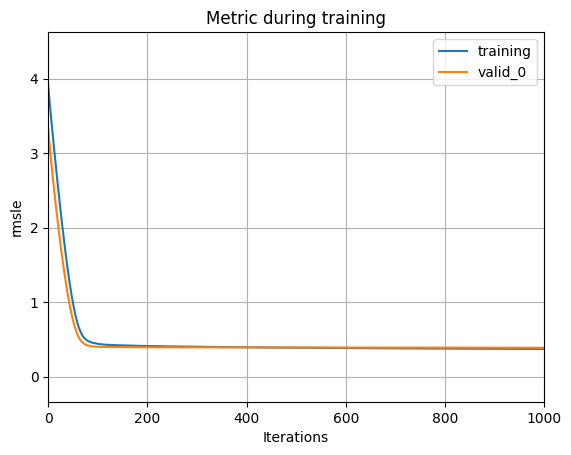

In [10]:
best_score = model.best_score_

y_pred = model.predict(X_validation)
rmsle_score = mean_squared_log_error(y_validation, y_pred, squared=False)
print(best_score, rmsle_score)

lgbm.plot_metric(model)
plt.show()

# In-sample predictions (Optional)

## Load the trained model

In [ ]:
#--- Load the trained model ---#
trained_models_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
lgbm_dir = trained_models_dir/ "lgbm_scaled_387"
model = joblib.load(lgbm_dir / "TrainedModel_scaled_387.joblib")
model

LGBMRegressor(boost_from_average=False, early_stopping_round=100,
              feature_fraction=0.5, learning_rate=0.02, max_bin=100,
              min_data_in_leaf=255, n_estimators=1000, num_leaves=255,
              objective='tweedie', seed=42, subsample=0.5, subsample_freq=1,
              tweedie_variance_power=1.1, verbose=-1)

In [11]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.07428931643416213,
 'max_depth': 11,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_leaves': 450,
 'objective': 'tweedie',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 0.8,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'early_stopping_round': 100,
 'verbose': -1,
 'seed': 42,
 'tweedie_variance_power': 1.2,
 'min_data_in_leaf': 200,
 'feature_fraction': 0.6000000000000001,
 'max_bin': 132,
 'bagging_freq': 1,
 'min_data_per_groups': 100}

## Make in-sample prediction

In [12]:
# We use the last 30 days of the train dataset to make in-sample predictions
date_index = X_tr.index.get_level_values(1)
date_mask = date_index > (date_index.max() - np.timedelta64(30, "D"))
X_tr_recent = X_tr.loc[date_mask]
y_tr_recent = y_tr.loc[date_mask]

print("Start date is ", X_tr_recent.index.min()[1], "\nEnd date is ", X_tr_recent.index.max()[1])

Start date is  2017-06-17 00:00:00 
End date is  2017-07-16 00:00:00


In [13]:
# Get in-sample predictions.
y_tr_pred = model.predict(X=X_tr_recent)

# Convert model predictions to a dataframe.
insample_result_df = pd.DataFrame(
    data={"y_pred": y_tr_pred, "y_true": y_tr_recent["sales"].values},
    index=X_tr_recent.index
    )

print(rmsle(insample_result_df["y_true"].values, insample_result_df["y_pred"].values))
display(insample_result_df)

('rmsle', 0.3693444395054743, False)


y_pred  y_true
id            date                      
10_AUTOMOTIVE 2017-06-17    2.95    3.00
              2017-06-18    3.05    4.00
              2017-06-19    2.12    0.00
              2017-06-20    1.72    2.00
              2017-06-21    1.60    1.00
...                          ...     ...
9_SEAFOOD     2017-07-12   14.13   13.57
              2017-07-13   14.79   17.71
              2017-07-14   16.86   15.38
              2017-07-15   25.09   35.85
              2017-07-16   25.12   18.33

[53460 rows x 2 columns]

In [14]:
# Save the result
trained_models_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
lgbm_dir = trained_models_dir/ "lgbm_scaled_387"
result_dir = lgbm_dir/ "InSample_results"
result_dir.mkdir(exist_ok=True)

out_dir = result_dir / "InsampleForecast_scaled_387_valsplit.parquet"
insample_result_df.to_parquet(out_dir)

## Plot the in-sample prediction for a set of random stores

['53_HOME CARE' '28_SCHOOL AND OFFICE SUPPLIES' '46_FROZEN FOODS'
 '11_CLEANING' '40_BABY CARE' '42_SCHOOL AND OFFICE SUPPLIES'
 '13_BABY CARE' '21_BABY CARE' '28_SEAFOOD' '39_CELEBRATION'
 '19_MAGAZINES' '30_MAGAZINES']


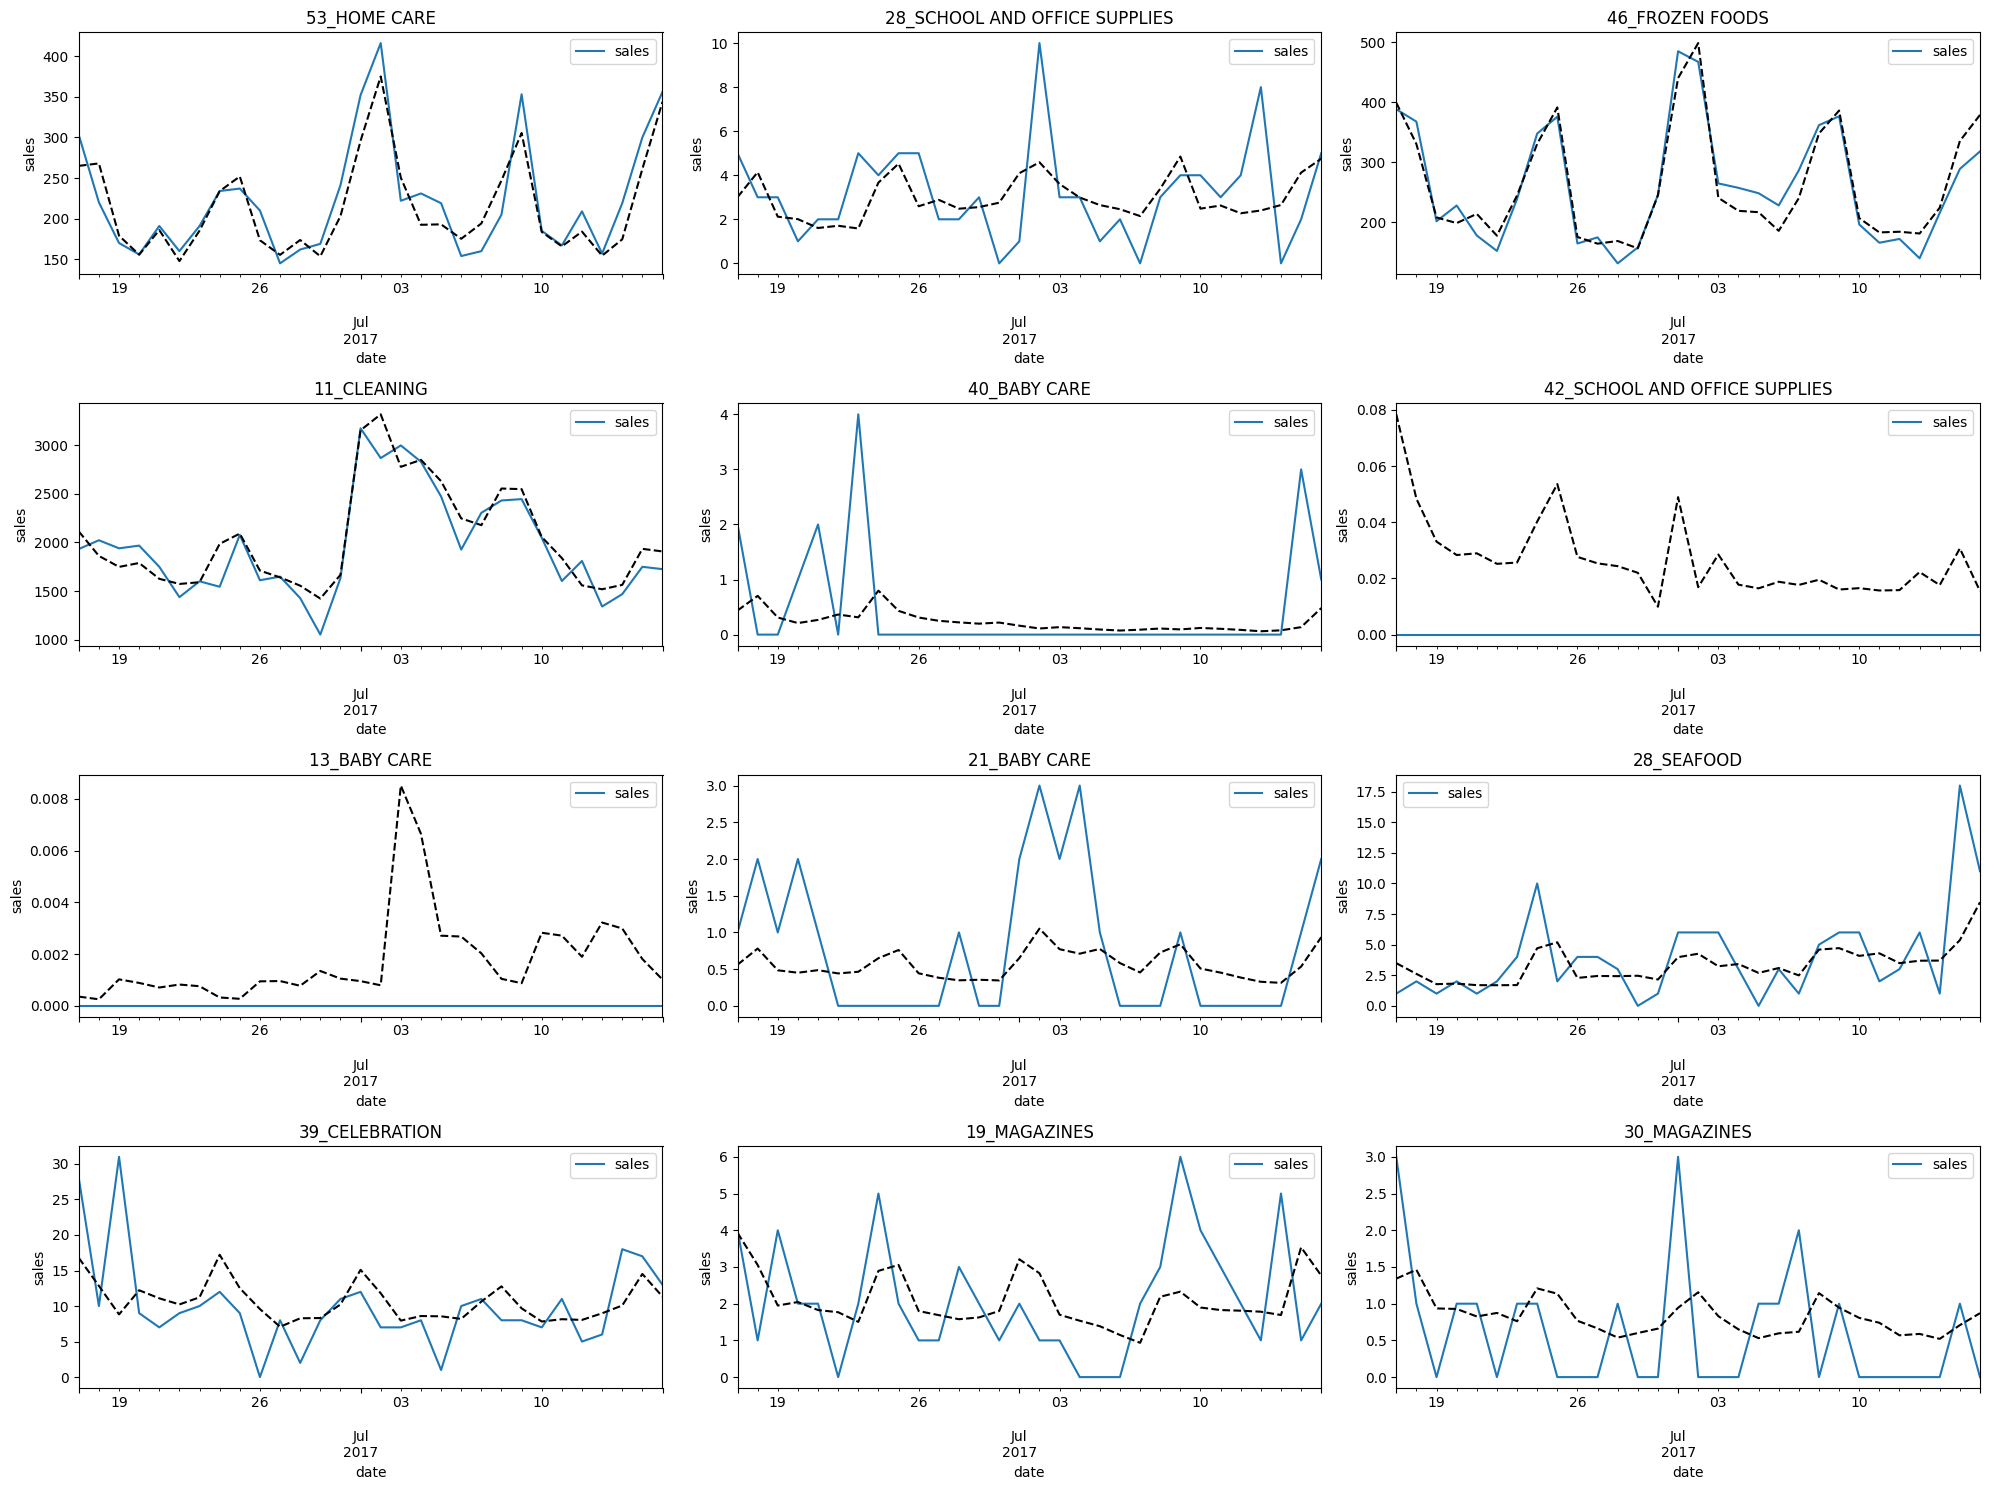

In [15]:
# Get 12 random stores
n_series = 12
# np.random.seed(0)
random_ids = np.random.choice(
    X_tr_recent.index.levels[0].values,
    size=n_series,
    replace=False)

print(random_ids)

# Plot subset of forecasts
fig, axes = plt.subplots(nrows=n_series // 3, ncols=3, figsize=[20, 15])

for index, ax in enumerate(axes.flatten()):
    random_id = random_ids[index]

    # Plot y_true (actual "sales")
    y_tr_recent.loc[random_id, ['sales']].plot(ax=ax)

    # Plot y_pred (in-sample forecasted "sales")
    insample_result_df.loc[random_id,"y_pred"].plot(ax=ax, linestyle="--", color="k")

    ax.set_title(random_id)
    ax.set_xlabel("date")
    ax.set_ylabel("sales")


plt.tight_layout()
plt.show()

In [16]:
print(model.n_features_)
feature_importances = model.feature_importances_
feature_importances.shape
model.feature_name_

58


['sales_lag_1',
 'sales_lag_31',
 'sales_lag_30',
 'sales_lag_28',
 'sales_lag_29',
 'sales_lag_7',
 'sales_lag_2',
 'sales_mean_1_28',
 'sales_mean_1_7',
 'sales_mean_7_7',
 'sales_mean_7_28',
 'sales_mean_1_32',
 'sales_mean_28_28',
 'sales_mean_1_31',
 'sales_mean_1_14',
 'sales_mean_1_30',
 'sales_mean_1_29',
 'sales_mean_28_7',
 'sales_mean_7_14',
 'sales_std_7_28',
 'sales_std_28_7',
 'sales_std_1_31',
 'sales_std_7_7',
 'sales_std_1_32',
 'sales_std_1_30',
 'sales_std_1_29',
 'sales_std_1_28',
 'sales_std_1_14',
 'sales_std_1_7',
 'sales_std_7_14',
 'sales_std_28_28',
 'transactions_mean_28_7',
 'transactions_std_28_7',
 'time_since_2013_01_01_00_00_00',
 'year',
 'quarter_of_year',
 'month_of_year',
 'week_of_year',
 'week_of_month',
 'day_of_month',
 'day_of_week',
 'is_weekend',
 'onpromotion',
 'oil_price_interpolated',
 'enc_family_mean',
 'enc_store_nbr_mean',
 'enc_city_mean',
 'enc_state_mean',
 'enc_type_mean',
 'enc_cluster_mean',
 'sales_ewma7_mean',
 'sales_ewma7_std

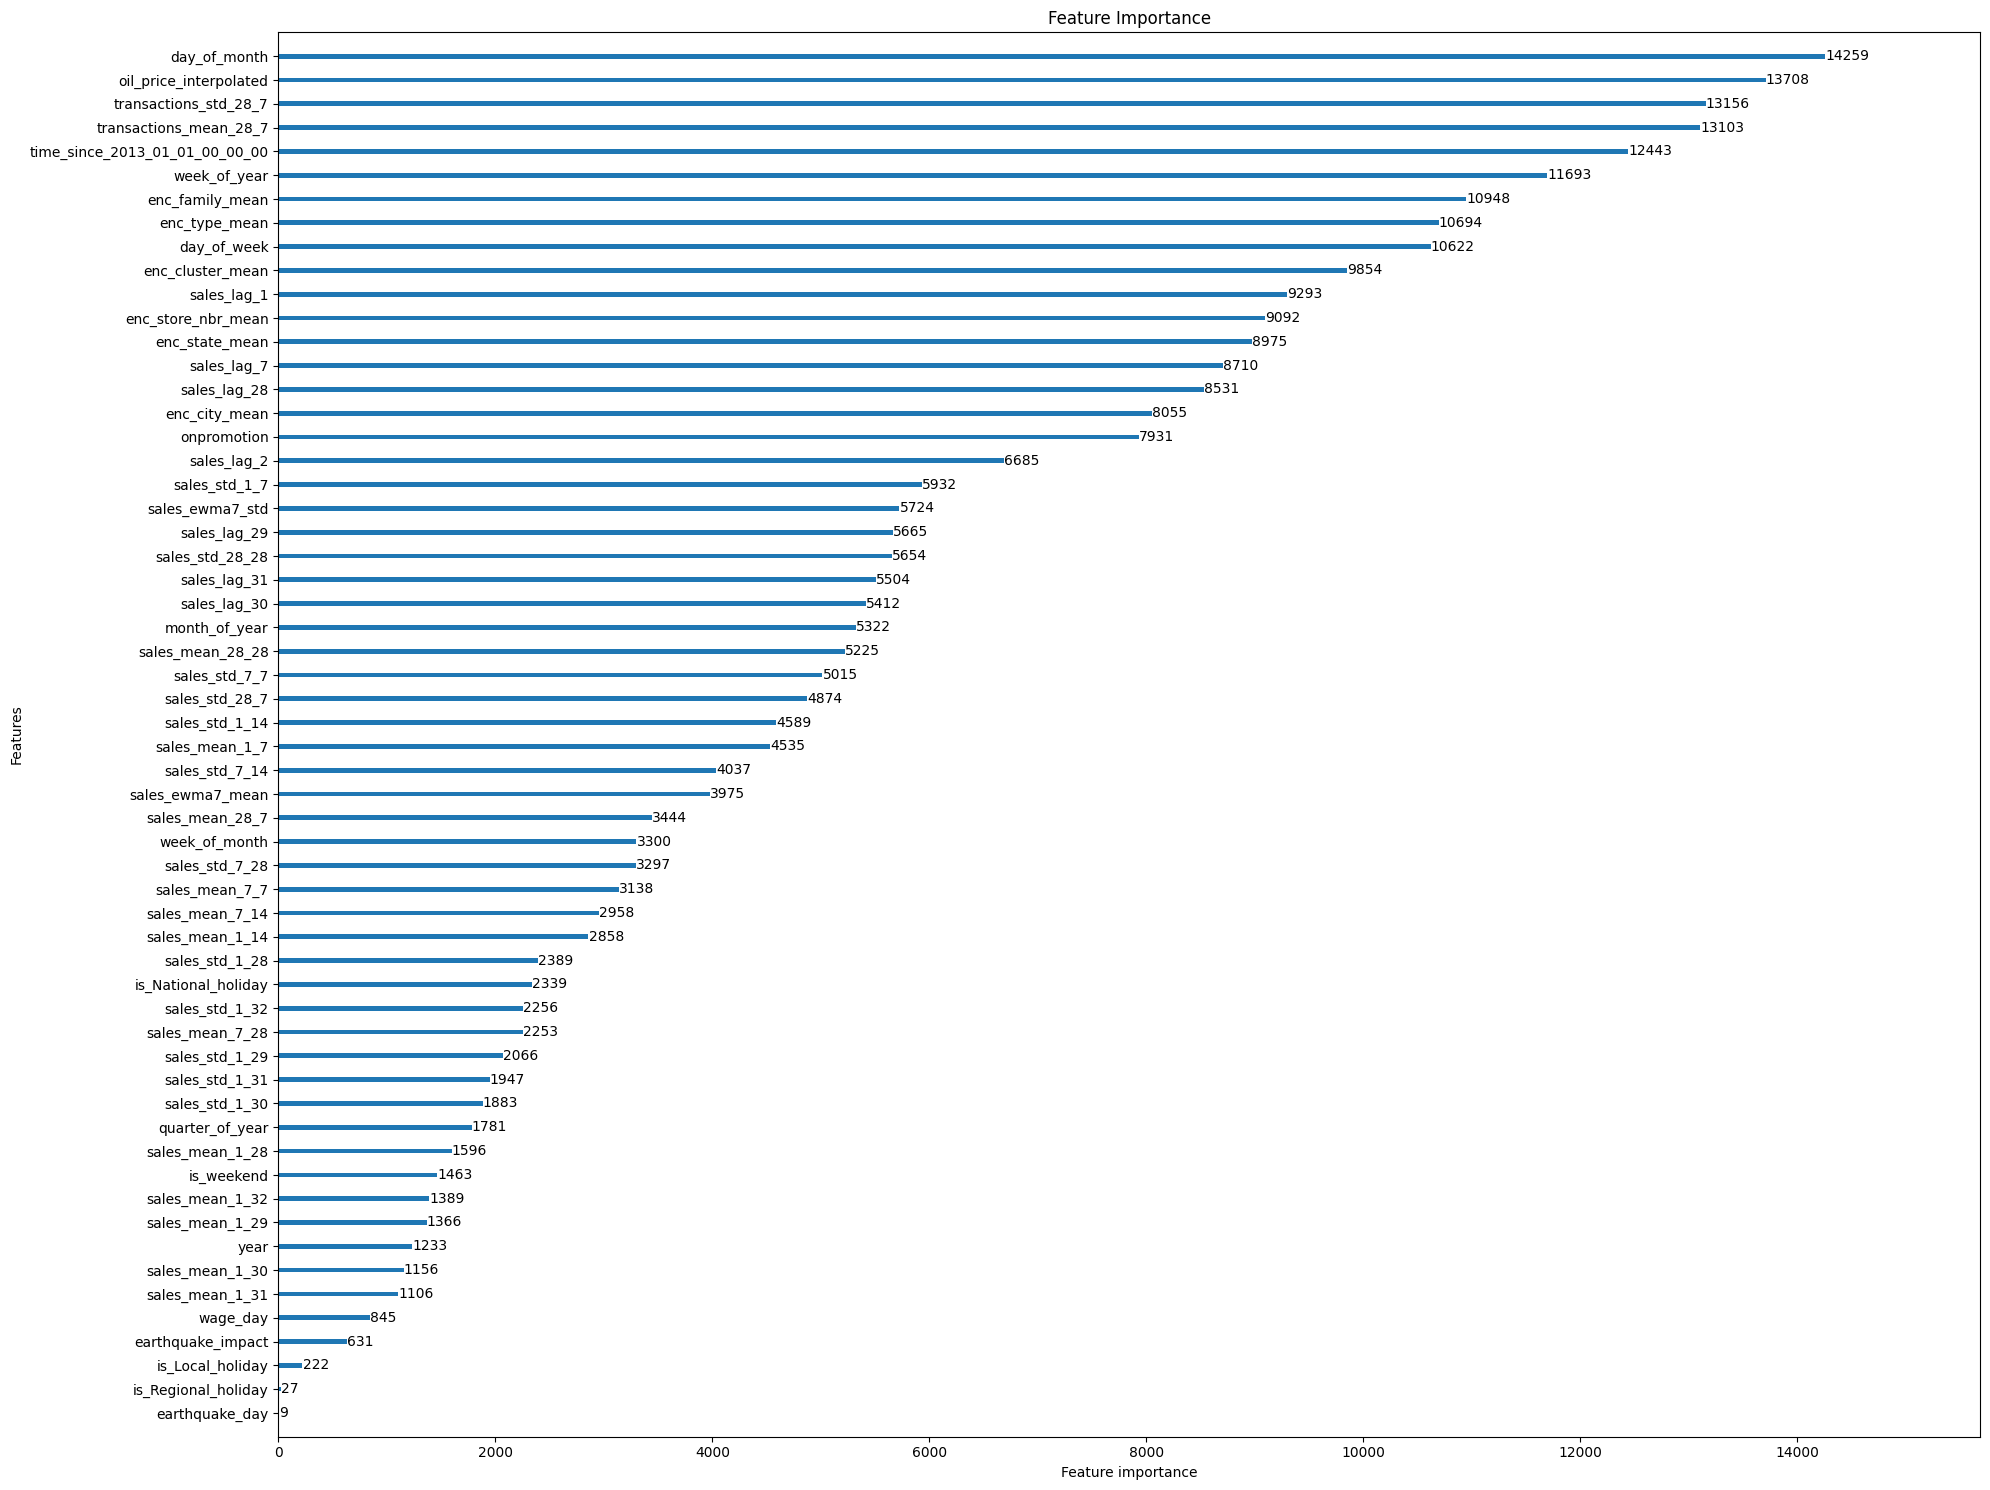

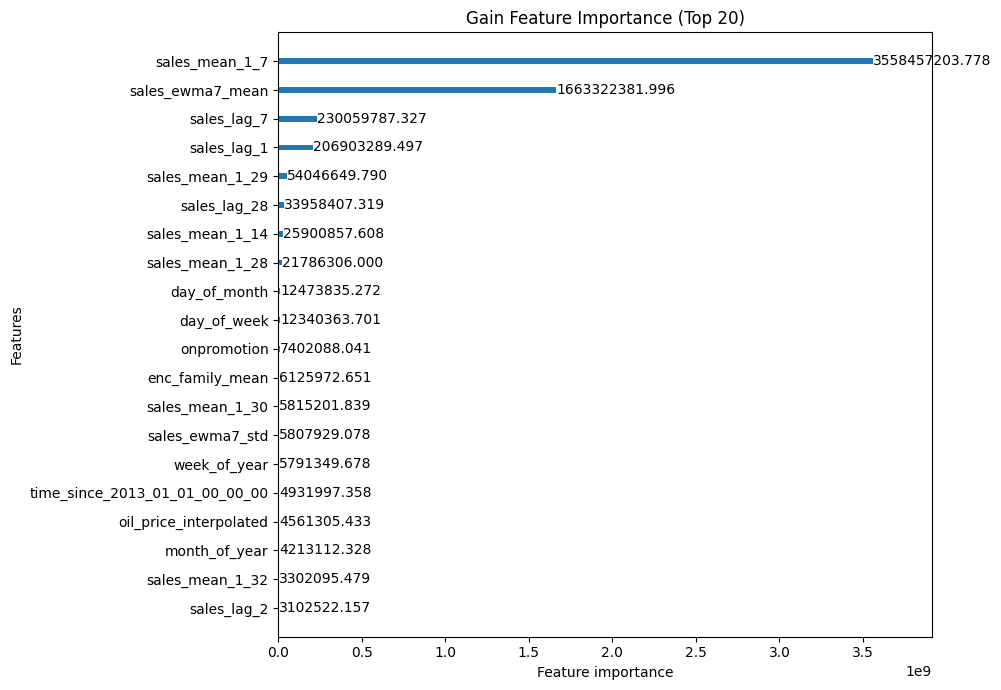

In [17]:
from lightgbm import plot_importance
# Plot feature importance
fig, ax = plt.subplots(figsize=(20, 15))
ax = plot_importance(
    model,
    grid=False,
    ax=ax
)
plt.title('Feature Importance')
plt.tight_layout()
plt.show();

# Plot gain feature importance
fig, ax = plt.subplots(figsize=(10, 7))
ax = plot_importance(
    model,
    importance_type="gain",     #If “gain”, result contains total gains of splits which use the feature.
    max_num_features=20,
    grid=False,
    ax=ax
)

plt.title('Gain Feature Importance (Top 20)')
plt.tight_layout()
plt.show();

# Feature selection

In [ ]:
# cols = [
#     'sales_lag_1', 'sales_lag_31', 'sales_lag_30', 'sales_lag_28',
#     'sales_lag_29', 'sales_lag_7', 'sales_lag_2', 'sales_mean_1_28',
#     'sales_mean_1_7', 'sales_mean_7_7', 'sales_mean_7_28',
#     'sales_mean_1_32', 'sales_mean_28_28', 'sales_mean_1_31',
#     'sales_mean_1_14', 'sales_mean_1_30', 'sales_mean_1_29',
#     'sales_mean_28_7', 'sales_mean_7_14', 'sales_std_7_28',
#     'sales_std_28_7', 'sales_std_1_31', 'sales_std_7_7', 'sales_std_1_32',
#     'sales_std_1_30', 'sales_std_1_29', 'sales_std_1_28', 'sales_std_1_14',
#     'sales_std_1_7', 'sales_std_7_14', 'sales_std_28_28',
#     'transactions_mean_28_7', 'transactions_std_28_7',
#     'time_since_2013_01_01_00_00_00', 'year', 'quarter_of_year',
#     'month_of_year', 'week_of_year', 'week_of_month', 'day_of_month',
#     'day_of_week', 'is_weekend', 'onpromotion', 'oil_price_interpolated',
#     'enc_family_mean', 'enc_store_nbr_mean', 'enc_city_mean',
#     'enc_state_mean', 'enc_type_mean', 'enc_cluster_mean',
#     'sales_ewma7_mean', 'sales_ewma7_std'
# ]

# params_2 = {
#     'boosting_type': 'gbdt',
#     'objective': 'tweedie',
#     'tweedie_variance_power': 1.1,
#     'metric': 'rmse',
#     'subsample': 0.5,
#     'subsample_freq': 1,
#     'learning_rate': 0.02,
#     'num_leaves': 2**8-1,                    # 2^tree_depth - 1
#     'min_data_in_leaf': 2**8-1,
#     'feature_fraction': 0.5,
#     'max_bin': 100,
#     'n_estimators': 1000,
#     'boost_from_average': False,
#     # 'early_stopping_round': int(0.1*1000),        # 10% * n_estimators
#     'verbose': -1,
#     "seed": 42,
#     "categorical_feature=name": cat_cols
# }

# model = LGBMRegressor(**params_2)

# from sklearn.feature_selection import RFECV    #Recursive feature elimination with cross-validation to select features
# from sklearn.model_selection import TimeSeriesSplit

# select = RFECV(estimator=model, scoring ="neg_mean_squared_log_error", cv = TimeSeriesSplit(n_splits = 5))
# select.fit(X_tr[cols], y_tr.sales)

# mask = select.get_support()   #Get a mask or integer index of the features selected
# list_column = np.array(X_tr.columns.to_list()[1::])[mask].tolist()


# print("Optimal number of features : %d" % select.n_features_)
# min_features_to_select = 1
# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (accuracy)")
# plt.plot(
#     range(min_features_to_select, len(select.cv_results_["mean_test_score"]) + min_features_to_select),
#     select.cv_results_["mean_test_score"],
# )
# plt.show()


# # Save the fitted select
# trained_models_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
# lgbm_dir = trained_models_dir/ "lgbm_scaled_params2"
# lgbm_dir.mkdir(exist_ok=True)

# out_dir = lgbm_dir/ "Select_scaled_params2_valsplit.joblib"
# joblib.dump(select, out_dir)